In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Copy the dataset into tmp folder

In [2]:
cp -r '/content/gdrive/MyDrive/Dataset_Canang' '/tmp/'

In [6]:
import os
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))

    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)

    shuffled = random.sample(all_files, n_files)

    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]

    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)

    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

Make directory for Train and Test dataset

In [4]:
!mkdir '/tmp/Dataset/'
!mkdir '/tmp/Dataset/Test'
!mkdir '/tmp/Dataset/Train'
!mkdir '/tmp/Dataset/Test/Canang Goak'
!mkdir '/tmp/Dataset/Test/Canang Ituk-Ituk'
!mkdir '/tmp/Dataset/Test/Canang Sari'
!mkdir '/tmp/Dataset/Test/Canang Tangkih'
!mkdir '/tmp/Dataset/Train/Canang Goak'
!mkdir '/tmp/Dataset/Train/Canang Ituk-Ituk'
!mkdir '/tmp/Dataset/Train/Canang Sari'
!mkdir '/tmp/Dataset/Train/Canang Tangkih'

Split and shuffle the Dataset

In [7]:
Source1="/tmp/Dataset_Canang/Canang Goak/"
Train1="/tmp/Dataset/Train/Canang Goak/"
Test1="/tmp/Dataset/Test/Canang Goak/"
Source2="/tmp/Dataset_Canang/Canang Ituk-ituk/"
Train2="/tmp/Dataset/Train/Canang Ituk-Ituk/"
Test2="/tmp/Dataset/Test/Canang Ituk-Ituk/"
Source3="/tmp/Dataset_Canang/Canang Sari/"
Train3="/tmp/Dataset/Train/Canang Sari/"
Test3="/tmp/Dataset/Test/Canang Sari/"
Source4="/tmp/Dataset_Canang/Canang Tangkih/"
Train4="/tmp/Dataset/Train/Canang Tangkih/"
Test4="/tmp/Dataset/Test/Canang Tangkih/"
split_data(Source1,Train1,Test1,.90)
split_data(Source2,Train2,Test2,.90)
split_data(Source3,Train3,Test3,.90)
split_data(Source4,Train4,Test4,.90)

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
img_height = 300
img_width = 300
batch_size = 30

In [9]:
model = keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

In [10]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/Dataset/Train",
    labels="inferred",
    label_mode='categorical',
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.110,
    subset="training",
)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/Dataset/Train",
    labels="inferred",
    label_mode='categorical',
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  
    shuffle=True,
    seed=123,
    validation_split=0.110,
    subset="validation",
)

Found 730 files belonging to 4 classes.
Using 650 files for training.
Found 730 files belonging to 4 classes.
Using 80 files for validation.


In [11]:
def augment(images, label):
    images = tf.cast(images, tf.float32)
    images = images / 255.0 
    images = tf.image.random_brightness(images,max_delta=0.5)
    return images, label

In [12]:
train_example=650
train_batches = ds_train.cache().shuffle(train_example//4).batch(batch_size).map(augment).prefetch(1)
validation_batches = ds_validation.cache().batch(batch_size).map(augment)

In [13]:
from keras_preprocessing.image import ImageDataGenerator
train_batches = ImageDataGenerator(
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       7

In [16]:
history = model.fit(ds_train, epochs=10, validation_data=ds_validation, verbose=2)

Epoch 1/10
22/22 - 94s - loss: 34.3601 - accuracy: 0.4923 - val_loss: 0.3978 - val_accuracy: 0.8500
Epoch 2/10
22/22 - 51s - loss: 0.1898 - accuracy: 0.9277 - val_loss: 0.1631 - val_accuracy: 0.9875
Epoch 3/10
22/22 - 41s - loss: 0.1061 - accuracy: 0.9600 - val_loss: 0.5025 - val_accuracy: 0.8625
Epoch 4/10
22/22 - 41s - loss: 0.0853 - accuracy: 0.9677 - val_loss: 0.7473 - val_accuracy: 0.8500
Epoch 5/10
22/22 - 41s - loss: 0.0519 - accuracy: 0.9785 - val_loss: 0.1807 - val_accuracy: 0.9500
Epoch 6/10
22/22 - 41s - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.2020 - val_accuracy: 0.9625
Epoch 7/10
22/22 - 42s - loss: 5.7219e-04 - accuracy: 1.0000 - val_loss: 0.2614 - val_accuracy: 0.9625
Epoch 8/10
22/22 - 42s - loss: 3.2461e-04 - accuracy: 1.0000 - val_loss: 0.2549 - val_accuracy: 0.9625
Epoch 9/10
22/22 - 41s - loss: 9.1123e-05 - accuracy: 1.0000 - val_loss: 0.2557 - val_accuracy: 0.9625
Epoch 10/10
22/22 - 41s - loss: 6.8344e-05 - accuracy: 1.0000 - val_loss: 0.2579 - val_accuracy:

Text(0.5, 1.0, 'Training and validation loss')

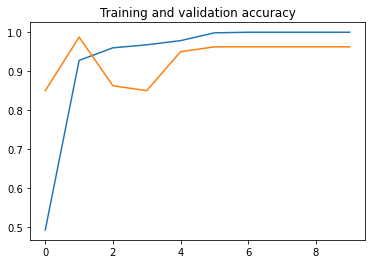

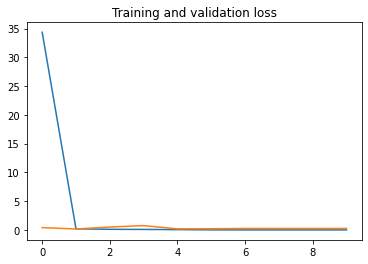

In [17]:
import matplotlib.pyplot as plt
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc))

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

Saving the Model

In [ ]:
tf.saved_model.save(model, '/tmp/save/1')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /tmp/save/1/assets


In [ ]:
!zip -r '/tmp/saved_model.zip' '/tmp/save'

  adding: tmp/save/ (stored 0%)
  adding: tmp/save/1/ (stored 0%)
  adding: tmp/save/1/assets/ (stored 0%)
  adding: tmp/save/1/saved_model.pb (deflated 89%)
  adding: tmp/save/1/variables/ (stored 0%)
  adding: tmp/save/1/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: tmp/save/1/variables/variables.index (deflated 67%)


In [ ]:
!cp '/tmp/saved_model2.zip' '/content/gdrive/MyDrive/saved_model2.zip'

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


Test the model using test dataset

In [19]:
from keras.preprocessing import image
image_path='/tmp/Dataset/Test/'
images = []
for jenis in os.listdir(image_path):
    for img in os.listdir(image_path+jenis):
        img = os.path.join(image_path+jenis, img)
        img = image.load_img(img, target_size=(300, 300))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)


# stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images, batch_size=20)
i=0
acc=0
for jenis in os.listdir(image_path):
    for img in os.listdir(image_path+jenis):
        if jenis=='Canang Goak' and classes[i]==0:
            acc+=1
        if jenis=='Canang Ituk-Ituk' and classes[i]==1:
            acc+=1
        if jenis=='Canang Sari' and classes[i]==2:
            acc+=1
        if jenis=='Canang Tangkih' and classes[i]==3:
            acc+=1
        i+=1
acc=acc/i*100
print("Accuracy = {}%".format(acc))

Accuracy = 97.5609756097561%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
